## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.datasets import TranslationDataset, Multi30k
# from torchtext.data import Field, BucketIterator

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import random_split

import pandas as pd

import spacy
import collections

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
tokenizer_W = WordPunctTokenizer()

def tokenize(text):
    return tokenizer_W.tokenize(text.lower())

def yield_tokens(data_iter, tokenizer, language):
    language_index = {'src': 1, 'trg': 0}[language]
    
    for item in data_iter:
        yield tokenizer(item[language_index])

In [4]:
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
init_token = '<sos>'
eos_token = '<eos>'

data_df = pd.read_csv(path_do_data, sep='\t', names=['src', 'trg'])
data_tuples = list(data_df.to_records(index=False))

data_df

,src,trg
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...
...,...,...
49995,The spacious air-conditioned rooms open out to...,Просторные номера с кондиционером выходят на с...
49996,Minsk Ring road is a 5-minute drive from the p...,Минская кольцевая автомобильная дорога проходи...
49997,There is a private bathroom with a shower.,В собственной ванной комнате установлен душ.
49998,It is a 15-minute drive from Malacca Town Cent...,За 15 минут вы доедете до центра города Малакк...


In [5]:
total_data = to_map_style_dataset(data_tuples)

train_len = int(len(total_data) * 0.8)
valid_len = int(len(total_data) * 0.15)
test_len = len(total_data) - train_len - valid_len

train_data, valid_data, test_data = random_split(total_data, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

In [6]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [9]:
counter_src = collections.Counter()
counter_trg = collections.Counter()

for src, trg in train_data:
    counter_src.update(tokenize(src))
    counter_trg.update(tokenize(trg))

def apply_min_freq(counter, min_freq):
    return {word: freq for word, freq in counter.items() if freq >= min_freq}

filtered_vocab_src = apply_min_freq(counter_src, 3)
filtered_vocab_trg = apply_min_freq(counter_trg, 3)

vocab_src = build_vocab_from_iterator([filtered_vocab_src], specials=specials)
vocab_trg = build_vocab_from_iterator([filtered_vocab_trg], specials=specials)

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

itos_src = vocab_src.get_itos()  
itos_trg = vocab_trg.get_itos()

def collate_batch(batch):
    batch_size = len(batch)

    max_src_len = max(len(tokenize(src)) for src, trg in batch) + 2  # +2 for <sos> and <eos>
    max_trg_len = max(len(tokenize(trg)) for src, trg in batch) + 2  # +2 for <sos> and <eos>

    src_batch = torch.full((batch_size, max_src_len), vocab_src['<pad>'], dtype=torch.long)
    trg_batch = torch.full((batch_size, max_trg_len), vocab_trg['<pad>'], dtype=torch.long)

    for i, (src, trg) in enumerate(batch):
        src_tokens = [vocab_src['<sos>']] + [vocab_src[token] for token in tokenize(src)] + [vocab_src['<eos>']]
        trg_tokens = [vocab_trg['<sos>']] + [vocab_trg[token] for token in tokenize(trg)] + [vocab_trg['<eos>']]

        src_batch[i, :len(src_tokens)] = torch.tensor(src_tokens, dtype=torch.long)
        trg_batch[i, :len(trg_tokens)] = torch.tensor(trg_tokens, dtype=torch.long)

    src_batch = src_batch.transpose(0, 1)
    trg_batch = trg_batch.transpose(0, 1)

    return src_batch, trg_batch

In [10]:
print(f"Unique tokens in source vocabulary: {len(vocab_src)}")
print(f"Unique tokens in target vocabulary: {len(vocab_trg)}")

Unique tokens in source vocabulary: 6711
Unique tokens in target vocabulary: 9310


Here are tokens from original (RU) corpus:

In [11]:
itos_src[::1000]

['<unk>', 'palma', 'groves', 'biscuits', 'mayan', 'states', 'malagueta']

And from target (EN) corpus:

In [12]:
itos_trg[::1000]

['<unk>',
 'дерева',
 'downtown',
 'кататься',
 'центрами',
 'шах',
 'margarita',
 'трибхуван',
 'дагомыс',
 'стереосистемой']

And here is example from train dataset:

In [13]:
print(tokenize(train_data[0][0]))
print(tokenize(train_data[0][1]))

['each', 'has', 'a', 'bathroom', 'with', 'a', 'bath', 'and', 'a', 'shower', ',', 'as', 'well', 'as', 'a', 'minibar', 'and', 'a', 'tv', '.']
['в', 'распоряжении', 'гостей', 'мини', '-', 'бар', ',', 'телевизор', 'и', 'ванная', 'комната', 'с', 'ванной', 'и', 'душем', '.']


Let's check the length distributions:

Length distribution in Train data


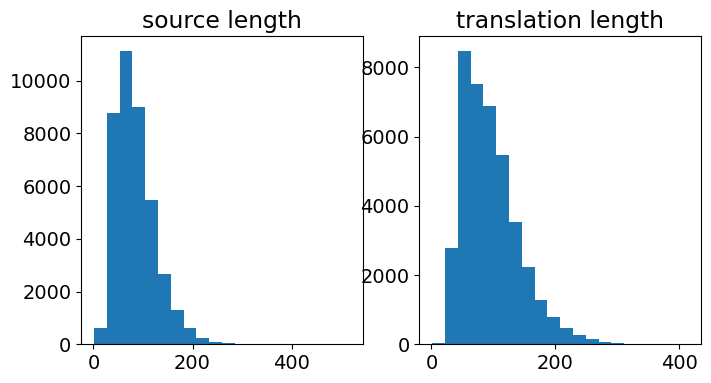

In [14]:
src_length = map(len, [x[0] for x in train_data])
trg_length = map(len, [x[1] for x in train_data])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


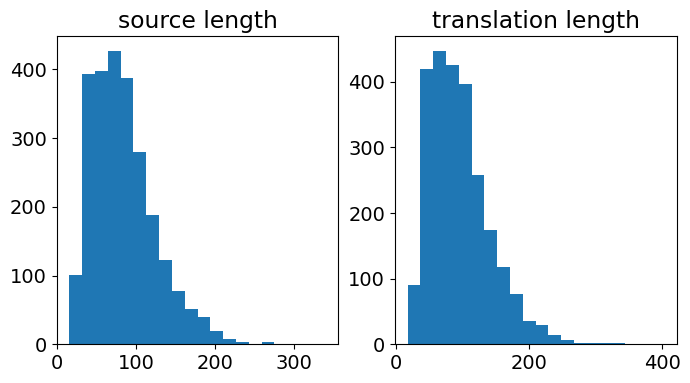

In [15]:
src_length = map(len, [x[0] for x in test_data])
trg_length = map(len, [x[1] for x in test_data])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cpu')

In [18]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, generator=torch.Generator().manual_seed(42))


In [32]:
for x in train_loader:
    break
print(x)
print(x[0].shape, x[1].shape)

(tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   6,    0,   15,  ...,    6, 1437, 3161],
        [ 138,    0,   50,  ...,  947,  421,  301],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]), tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [ 13,   5,  11,  ...,  13,   5, 356],
        [102,  71, 162,  ..., 428,  46,   0],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]]))
torch.Size([49, 128]) torch.Size([47, 128])


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_trg)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6711, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9310, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=9310, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,233,822 trainable parameters


In [24]:
PAD_IDX = vocab_trg['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [38]:
help(t.view)

Help on built-in function view:

view(...) method of torch.Tensor instance
    view(*shape) -> Tensor
    
    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different :attr:`shape`.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = d, \dots, d+k-1`,
    
    .. math::
    
      \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]
    
    Otherwise, it will not be possible to view :attr:`self` tensor as :attr:`shape`
    without copying it (e.g., via :meth:`contiguous`). When it is unclear whether a
    :meth:`view` can be performe

In [39]:
help(t.reshape)

Help on built-in function reshape:

reshape(...) method of torch.Tensor instance
    reshape(*shape) -> Tensor
    
    Returns a tensor with the same data and number of elements as :attr:`self`
    but with the specified shape. This method returns a view if :attr:`shape` is
    compatible with the current shape. See :meth:`torch.Tensor.view` on when it is
    possible to return a view.
    
    See :func:`torch.reshape`
    
    Args:
        shape (tuple of ints or int...): the desired shape



In [ ]:
h

In [37]:
t = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

print(t.shape)
t = t.view(5, 2)
print(t.shape)
t = t.reshape(-1)
print(t.shape)

torch.Size([10])
torch.Size([5, 2])
torch.Size([10])


In [40]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch[0]
        trg = batch[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        # trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [41]:
for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01


__Let's take a look at our network quality__:

In [104]:
del utils

In [105]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [106]:
batch = next(iter(test_iterator))

In [107]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the property offers a 24 - hour front desk . .

Original: this property also features free wifi .
Generated: free wifi access . . . .



In [108]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [109]:
import tqdm

In [110]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.87it/s]


In [111]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.139920232081806